# Clustering Zooniverse Marks to count Iguanas
The goal is to find the best method to cluster the data and find the best number of clusters.
The benchmark is a gold standard dataset obtained by experts.

In [823]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
sys.path.append("../zooniverse")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Intro
### Retrieve a Classification report from Zooniverse
Export the classification export from your zooniverse project.
https://www.zooniverse.org/lab/11905/data-exports

This leads to a csv file which can be used for the analysis which should be renamed to `iguanas-from-above-classifications.csv` and placed in the `input_path` directory.
The methods do not use methods from zooniverse. It is a custom implementation.

An alternative would be to use the [code provided by zooniverse](https://github.com/zooniverse/Data-digging/tree/master/notebooks_ProcessExports)
(Bird Count Example)[https://github.com/zooniverse/Data-digging/blob/master/scripts_ProjectExamples/seabirdwatch/bird_count.py]

This notebooks assumes the data is flat and prepared. An alternative format would be the [cesar aggregation format](https://github.com/zooniverse/aggregation-for-caesar)

Used Methods are:

### DBSCAN 
It does not require the number of clusters to be specified. It is used here because, but has min_samples and eps as hyperparameters which need to be found. [Link](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html)
For finding eps and min_sample a simple **grid search** is used.
Additionally, DBSCAN not assume a specific shape for the clusters (K-means assumes clusters are gaussian in shape) even though we should assume that points around an iguana is gaussian shaped.

### HDBSCAN
It is an extension of DBSCAN which is more robust to hyperparameter settings as it finds epsilon and min_samples automatically. [Link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html)

### Processing workflow

The Data is flatted and filtered
![Image](images/dataprocessing-DataFiltering.png)

In each phase we have the following number of images if they are filtered for at least 4 true marks by users
1. phase 105
2. phase 160
3. phase 86


## Load the data

In [824]:
from zooniverse.utils.data_format import data_prep
from pathlib import Path

## Input Path of all the data
input_path =Path("/Users/christian/data/zooniverse")

reprocess = False # if True, the raw classification data is reprocessed. If False, the data is loaded from disk

# Phase Selection
# phase_tag = "Iguanas 1st launch"
phase_tag = "Iguanas 2nd launch"
# phase_tag = "Iguanas 3rd launch"


debug = True # debugging with a smaller dataset
plot_diagrams = True # plot the diagrams to disk for the clustering methods
show_plots = True # show the plots in the notebook
user_threshold = None # in a number, filter records which have less than these user interactions.


### use either the subset of the subset
use_gold_standard_subset = "expert_goldstandard" # Use the X-T2-GS-results-5th-0s as the basis
# use_gold_standard_subset = "expert" # Use the expert-GS-Xphase as the basis

# Location for the analysis Results
output_path = Path(input_path.joinpath(f"2024_02_07_{use_gold_standard_subset}_analysis").joinpath(phase_tag))
output_path.mkdir(exist_ok=True, parents=True)

# Location for plots
output_plot_path = output_path.joinpath("plots")
output_plot_path.mkdir(parents=True, exist_ok=True)

if reprocess:
    ds_stats = data_prep(phase_tag=phase_tag, 
                         output_path=output_path, 
                         input_path=input_path,
                         filter_combination=use_gold_standard_subset)
    print(ds_stats)
    


In [825]:

import pandas as pd
from zooniverse.analysis import get_annotation_count_stats
from zooniverse.utils.filters import filter_df_user_threshold
from zooniverse.config import get_config

## Look into the config

In [826]:
config = get_config(phase_tag=phase_tag, input_path=input_path, output_path=output_path)
config

{'annotations_source': PosixPath('/Users/christian/data/zooniverse/IguanasFromAbove/2023-10-15/iguanas-from-above-classifications.csv'),
 'goldstandard_data': PosixPath('/Users/christian/data/zooniverse/Images/Zooniverse_Goldstandard_images/expert-GS-2ndphase.csv'),
 'gold_standard_image_subset': PosixPath('/Users/christian/data/zooniverse/Images/Zooniverse_Goldstandard_images/2-T2-GS-results-5th-0s.csv'),
 'image_source': PosixPath('/Users/christian/data/zooniverse/Images/Zooniverse_Goldstandard_images/2nd launch_without_prefix'),
 'yes_no_dataset': PosixPath('/Users/christian/data/zooniverse/2024_02_07_expert_goldstandard_analysis/Iguanas 2nd launch/yes_no_dataset_Iguanas 2nd launch.csv'),
 'flat_dataset': PosixPath('/Users/christian/data/zooniverse/2024_02_07_expert_goldstandard_analysis/Iguanas 2nd launch/flat_dataset_Iguanas 2nd launch.csv'),
 'merged_dataset': PosixPath('/Users/christian/data/zooniverse/2024_02_07_expert_goldstandard_analysis/Iguanas 2nd launch/merged_dataset_gol

### Optional Debugging

In [827]:
if plot_diagrams == False:
    output_plot_path = None


df_merged_dataset = pd.read_csv(config["merged_dataset"])


df_goldstandard_expert_count = pd.read_csv(config["goldstandard_data"], sep=";")

## Debugging helpers
if phase_tag == "Iguanas 1st launch":    
    if debug:

        df_merged_dataset = df_merged_dataset[df_merged_dataset.image_name.isin(["SFM01-2-2-2_333.jpg", "SFM01-2-2-2_334.jpg", "SFM01-2-2-3_201.jpg"])]

elif phase_tag == "Iguanas 2nd launch":
    if debug:
        df_merged_dataset = df_merged_dataset[
           df_merged_dataset.image_name.isin(["FMO03-1_65.jpg", "FMO03-1_72.jpg", "MBN04-2_182.jpg", "EGI08-2_78.jpg"])]
           # df_merged_dataset.image_name.isin(["FMO03-1_72.jpg"])]

    
elif phase_tag == "Iguanas 3rd launch":

    # this user is a spammer
    df_merged_dataset = df_merged_dataset[df_merged_dataset.user_id != 2581179]
    
    if debug:
        df_merged_dataset = df_merged_dataset[
           df_merged_dataset.image_name.isin(["FMO03-2_70.jpg", "MBN04-2_182.jpg", "EGI08-2_78.jpg"])]
            
    


## Look at the data


In [828]:
## Look at the data
df_merged_dataset.drop("user_name", axis=1)


,Unnamed: 0,flight_site_code,image_name,subject_id,x,y,tool_label,phase_tag,user_id,mission_name,image_path,width,height
15,15,FMO03,FMO03-1_72.jpg,72338635,32.429527,409.518311,Adult Male with a lek,Iguanas 2nd launch,1682891.0,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
16,16,FMO03,FMO03-1_72.jpg,72338635,58.991695,345.788910,"Others (females, young males, juveniles)",Iguanas 2nd launch,1682891.0,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
17,17,FMO03,FMO03-1_72.jpg,72338635,-2.480816,304.061401,"Others (females, young males, juveniles)",Iguanas 2nd launch,1682891.0,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
76,76,FMO03,FMO03-1_65.jpg,72338628,1462.498779,32.694767,Adult Male alone,Iguanas 2nd launch,2426126.0,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1467
77,77,FMO03,FMO03-1_65.jpg,72338628,1265.782471,140.750214,Adult Male alone,Iguanas 2nd launch,2426126.0,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1467
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7925,7925,FMO03,FMO03-1_65.jpg,72338628,1472.126465,30.358425,Adult Male alone,Iguanas 2nd launch,2012412.0,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1467
7926,7926,FMO03,FMO03-1_65.jpg,72338628,1267.915039,141.420746,Adult Male alone,Iguanas 2nd launch,2012412.0,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1467
7968,7968,FMO03,FMO03-1_72.jpg,72338635,51.778252,368.877380,"Others (females, young males, juveniles)",Iguanas 2nd launch,2439291.0,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
7969,7969,FMO03,FMO03-1_72.jpg,72338635,96.721016,468.095276,"Others (females, young males, juveniles)",Iguanas 2nd launch,2439291.0,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468


### Filter User if necessary and Marks


In [829]:
print(f"Before filtering: {df_merged_dataset.subject_id.nunique()}")
# There images in which some people said there are iguanas, but then didn't mark them. Clustering with fewer than 3 dots doesn't make sense
if user_threshold is not None:
    print(f"filtering records which have less than {user_threshold} interactions.")
    df_merged_dataset = filter_df_user_threshold(df_merged_dataset, user_threshold=user_threshold)
    
    
from zooniverse.utils.filters import filter_remove_marks
# Check if partials are still in the data. There shouldn't be any
df_merged_dataset = filter_remove_marks(df_merged_dataset)


2024-02-08 15:07:53.373 | WARNING  | zooniverse.utils.filters:filter_remove_marks:38 - removed 0 partial marks
2024-02-08 15:07:53.373 | WARNING  | zooniverse.utils.filters:filter_remove_marks:39 - After filter_func 3 images are left


Before filtering: 3


### Are there anonymous users in the data?
There should be

In [830]:
df_merged_dataset[df_merged_dataset.user_id.isnull().values]

,Unnamed: 0,flight_site_code,image_name,subject_id,x,y,tool_label,phase_tag,user_id,user_name,mission_name,image_path,width,height
372,372,EGI08,EGI08-2_78.jpg,72333835,296.092285,578.326233,"Others (females, young males, juveniles)",Iguanas 2nd launch,NaN,not-logged-in-47f0139c5cb138c60e2a,Gardner Islet,/Users/christian/data/zooniverse/Images/Zooniv...,1049,992
952,952,FMO03,FMO03-1_72.jpg,72338635,112.342903,448.233032,Adult Male alone,Iguanas 2nd launch,NaN,not-logged-in-c00b0dc393f39bb823b6,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
953,953,FMO03,FMO03-1_72.jpg,72338635,41.938354,393.932037,"Others (females, young males, juveniles)",Iguanas 2nd launch,NaN,not-logged-in-c00b0dc393f39bb823b6,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
954,954,FMO03,FMO03-1_72.jpg,72338635,831.429626,908.885071,"Others (females, young males, juveniles)",Iguanas 2nd launch,NaN,not-logged-in-c00b0dc393f39bb823b6,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
4266,4266,FMO03,FMO03-1_72.jpg,72338635,42.696671,397.324799,Adult Male alone,Iguanas 2nd launch,NaN,not-logged-in-50ee2f0c3d3c6b77f3b0,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
4267,4267,FMO03,FMO03-1_72.jpg,72338635,85.208626,456.883636,Adult Male alone,Iguanas 2nd launch,NaN,not-logged-in-50ee2f0c3d3c6b77f3b0,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
5137,5137,EGI08,EGI08-2_78.jpg,72333835,260.746826,605.096680,Adult Male alone,Iguanas 2nd launch,NaN,not-logged-in-e47366ca6e9955819908,Gardner Islet,/Users/christian/data/zooniverse/Images/Zooniv...,1049,992


In [831]:
df_merged_dataset["subject_id"].nunique()

3

In [832]:
## After filtering there
df_merged_dataset

,Unnamed: 0,flight_site_code,image_name,subject_id,x,y,tool_label,phase_tag,user_id,user_name,mission_name,image_path,width,height
15,15,FMO03,FMO03-1_72.jpg,72338635,32.429527,409.518311,Adult Male with a lek,Iguanas 2nd launch,1682891.0,databanana,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
16,16,FMO03,FMO03-1_72.jpg,72338635,58.991695,345.788910,"Others (females, young males, juveniles)",Iguanas 2nd launch,1682891.0,databanana,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
17,17,FMO03,FMO03-1_72.jpg,72338635,-2.480816,304.061401,"Others (females, young males, juveniles)",Iguanas 2nd launch,1682891.0,databanana,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
76,76,FMO03,FMO03-1_65.jpg,72338628,1462.498779,32.694767,Adult Male alone,Iguanas 2nd launch,2426126.0,CMManning,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1467
77,77,FMO03,FMO03-1_65.jpg,72338628,1265.782471,140.750214,Adult Male alone,Iguanas 2nd launch,2426126.0,CMManning,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7925,7925,FMO03,FMO03-1_65.jpg,72338628,1472.126465,30.358425,Adult Male alone,Iguanas 2nd launch,2012412.0,vada11,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1467
7926,7926,FMO03,FMO03-1_65.jpg,72338628,1267.915039,141.420746,Adult Male alone,Iguanas 2nd launch,2012412.0,vada11,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1467
7968,7968,FMO03,FMO03-1_72.jpg,72338635,51.778252,368.877380,"Others (females, young males, juveniles)",Iguanas 2nd launch,2439291.0,rozsanch,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468
7969,7969,FMO03,FMO03-1_72.jpg,72338635,96.721016,468.095276,"Others (females, young males, juveniles)",Iguanas 2nd launch,2439291.0,rozsanch,Montura,/Users/christian/data/zooniverse/Images/Zooniv...,1498,1468


In [833]:
# how many marks per user
df_merged_dataset[["user_id", "x"]].groupby("user_id").count().head()

,x
user_id,
1243697.0,8
1275665.0,2
1469510.0,9
1579315.0,4
1682891.0,7


### gold standard data
For reference

In [834]:
df_goldstandard_expert_count[df_goldstandard_expert_count["image_name"].isin(["SFM01-2-2-2_282.jpg", "SFM01-2-2-2_323.jpg"])]

,subspecies,island,site_name,subject_group,image_name,subject_id,presence_absence,count_male-lek,count_male-no-lek,count_others,count_partial,count_total,quality,condition,comment


In [835]:
df_goldstandard_expert_count.count_total.sum()

600

In [836]:
# look at the
df_goldstandard_expert_count.count()

subspecies           456
island               456
site_name            456
subject_group        456
image_name           456
subject_id           456
presence_absence     456
count_male-lek       456
count_male-no-lek    456
count_others         456
count_partial        456
count_total          456
quality              179
condition            179
comment               11
dtype: int64

In [837]:
fsum = df_goldstandard_expert_count[
    df_goldstandard_expert_count.image_name.isin(df_merged_dataset.image_name.unique())]

print(f"filtering the zooniverse classifications dataset for gold standard images the count_total of iguanas is: {fsum.count_total.sum()}, but it should be {df_goldstandard_expert_count.count_total.sum()}")
fsum


filtering the zooniverse classifications dataset for gold standard images the count_total of iguanas is: 10, but it should be 600


,subspecies,island,site_name,subject_group,image_name,subject_id,presence_absence,count_male-lek,count_male-no-lek,count_others,count_partial,count_total,quality,condition,comment
14,A. c. venustissimus,Española,Gardner Islet,Gardner Islet,EGI08-2_78.jpg,72333835,Y,0,1,0,0,1,Good,Visible,NaN
242,A. c. venustissimus,Floreana,Montura,Montura,FMO03-1_65.jpg,72338628,Y,0,4,1,0,5,Good,Visible,NaN
243,A. c. venustissimus,Floreana,Montura,Montura,FMO03-1_72.jpg,72338635,Y,1,0,3,0,4,Good,Visible,NaN


In [838]:
# How many images are left in the zooniverse dataset?
len(list(df_merged_dataset.image_name.unique()))

3

In [839]:
#Is there an image in the goldstandard, which is not in the classifcations?
len(set(df_goldstandard_expert_count.subject_id) - set(df_merged_dataset.subject_id.unique()))


df_goldstandard_expert_count.count_total.sum()
# df_merged_dataset[df_merged_dataset.image_name.isin(["SRL01-1-2_105.jpg"])]

600

In [840]:
df_goldstandard_expert_count[df_goldstandard_expert_count.image_name.isin(["SRL01-1-2_105.jpg"])]

,subspecies,island,site_name,subject_group,image_name,subject_id,presence_absence,count_male-lek,count_male-no-lek,count_others,count_partial,count_total,quality,condition,comment


In [841]:
T2_GS_results_5th_0s = pd.read_csv(config["gold_standard_image_subset"], sep=";")
T2_GS_results_5th_0s

,subject_id,Median0s,Mean0s,Max0s,Std0s,Median.r,Mean.r,Mode0s
0,72333244,1.0,1.636364,4,0.902138,1,2,1
1,72333835,1.0,1.000000,1,0.000000,1,1,1
2,72335422,1.0,1.500000,5,1.414214,1,2,1
3,72335435,2.0,1.666667,2,0.487950,2,2,2
4,72335541,2.0,2.190476,7,1.249762,2,2,2
...,...,...,...,...,...,...,...,...
164,72373289,1.0,1.000000,1,0.000000,1,1,1
165,72373315,6.0,5.647059,8,2.148871,6,6,6
166,72373321,15.0,14.842105,22,5.112764,15,15,19
167,72373336,6.5,7.166667,14,4.792764,7,7,1


## The gold standard vs. the expert count

In [842]:
# Double checking for the counts
gstd_5th = df_goldstandard_expert_count[df_goldstandard_expert_count.subject_id.isin(T2_GS_results_5th_0s.subject_id)].count_total.sum()
print(f"If the expert count ({config['goldstandard_data']})  is filtered for the subject ids in {config['gold_standard_image_subset']} the count_total is {gstd_5th} iguanas")

If the expert count (/Users/christian/data/zooniverse/Images/Zooniverse_Goldstandard_images/expert-GS-2ndphase.csv)  is filtered for the subject ids in /Users/christian/data/zooniverse/Images/Zooniverse_Goldstandard_images/2-T2-GS-results-5th-0s.csv the count_total is 589 iguanas


In [843]:
len(set(T2_GS_results_5th_0s.subject_id.unique()) - set(df_goldstandard_expert_count.subject_id))
df_goldstandard_expert_count["count_total"].sum()

600

In [844]:
df_merged_dataset["subject_id"].nunique()

3

In [845]:

df_goldstandard_expert_count = df_goldstandard_expert_count[
    df_goldstandard_expert_count.subject_id.isin(df_merged_dataset.subject_id.unique())]
df_goldstandard_expert_count = df_goldstandard_expert_count[["image_name", "subject_id", "count_total"]]

df_goldstandard_expert_count["count_total"].sum()

10

show plots: True


2024-02-08 15:07:55.362 | INFO     | zooniverse.utils.plotting:plot_zooniverse_user_marks_v2:143 - /Users/christian/data/zooniverse/2024_02_07_expert_goldstandard_analysis/Iguanas 2nd launch/plots/EGI08-2_78.jpg_markers.png


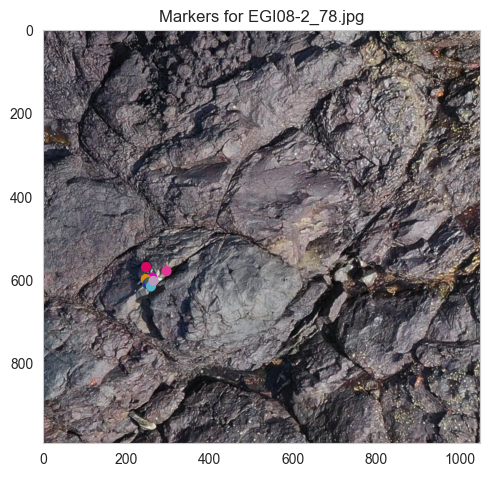

show plots: True


2024-02-08 15:07:55.905 | INFO     | zooniverse.utils.plotting:plot_zooniverse_user_marks_v2:143 - /Users/christian/data/zooniverse/2024_02_07_expert_goldstandard_analysis/Iguanas 2nd launch/plots/FMO03-1_65.jpg_markers.png


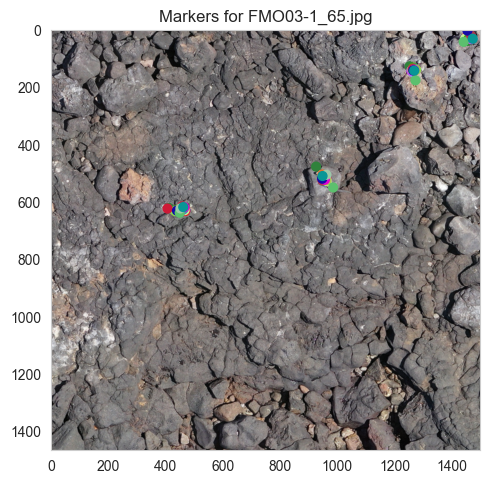

show plots: True


2024-02-08 15:07:56.477 | INFO     | zooniverse.utils.plotting:plot_zooniverse_user_marks_v2:143 - /Users/christian/data/zooniverse/2024_02_07_expert_goldstandard_analysis/Iguanas 2nd launch/plots/FMO03-1_72.jpg_markers.png


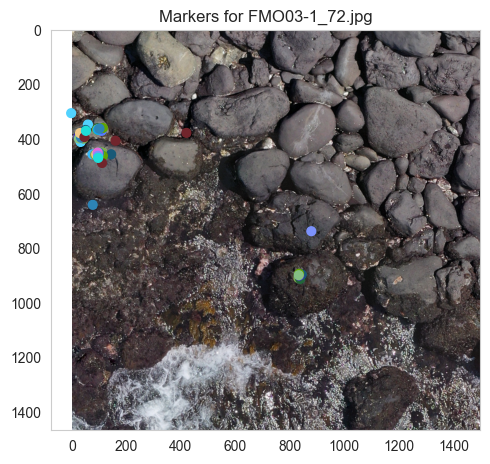

In [846]:
## plot some of the marks
from zooniverse.utils.plotting import plot_zooniverse_user_marks_v2
# FMO03-1_65
# EIG05-1_83.jpg # phase 
# MBN04-2_182.jpg # phase 3
# df_merged_dataset_filtered = df_merged_dataset[df_merged_dataset.image_name.isin(["ESCG02-1_19.jpg"])]
if phase_tag in["Iguanas 1st launch", "Iguanas 2nd launch"]  and  ( plot_diagrams or show_plots ) :
    for image_name, df_image_name in df_merged_dataset.groupby("image_name"):
        
        ## plot the marks
        markers_plot_path = plot_zooniverse_user_marks_v2(df_image_name,
                                                          image_path=df_image_name.iloc[0]["image_path"],
                                                          image_name=image_name,
                                                          output_path=output_plot_path, show=show_plots, title=f"Markers for {image_name}", fig_size=(5,5))
        

## Clustering

### Basic Statics like mean, median, mode

In [847]:
from sklearn.metrics import mean_squared_error
from zooniverse.analysis import kmeans_knee, get_mark_overview

basic_stats = []
kmeans_knee_stats = []
kmeans_silouettes = []
mse_errors = {}


for image_name, df_image_name in df_merged_dataset.groupby("image_name"):
    annotations_count = get_mark_overview(df_image_name)


    annotations_count_stats = get_annotation_count_stats(annotations_count=annotations_count,
                                                         image_name=df_image_name.iloc[0]["image_name"])


    ### basic statistics like mean, median
    basic_stats.append(annotations_count_stats)
    

df_basic_stats = pd.DataFrame(basic_stats)    

df_comparison = df_goldstandard_expert_count.merge(df_basic_stats, on='image_name', how='left')

df_comparison["count_total"].sum()
df_goldstandard_expert_count["count_total"].sum()

10

In [848]:
# There might be records with too few annotations
df_comparison[(df_comparison.count_total > 0) & (df_comparison.sum_annotations_count < 5)].sort_values(by="users", ascending=False)

,image_name,subject_id,count_total,median_count,mean_count,mode_count,users,sum_annotations_count,annotations_count


In [849]:
df_comparison[(df_comparison.count_total > 0) & (df_comparison.users < 5)].sort_values(by="users", ascending=False)


,image_name,subject_id,count_total,median_count,mean_count,mode_count,users,sum_annotations_count,annotations_count


In [850]:
df_comparison["count_total"].sum()

10

### Fill NaN values with 0 because the errors can't be calculated otherwise

In [851]:

## Fill NaN values with 0 because the errors can't be calculated otherwise
df_comparison.fillna(0, inplace=True)


In [852]:

mse_errors["median_count_rmse"] = mean_squared_error(df_comparison.count_total, df_comparison.median_count,
                                                     squared=False)
mse_errors["mean_count_rmse"] = mean_squared_error(df_comparison.count_total, df_comparison.mean_count, squared=False)
mse_errors["mode_count_rmse"] = mean_squared_error(df_comparison.count_total, df_comparison.mode_count, squared=False)

pd.Series(mse_errors)

median_count_rmse    0.816497
mean_count_rmse      1.199847
mode_count_rmse      0.577350
dtype: float64

It can be seen the knee method has a very high Root mean squared error. 

In [853]:
df_comparison

,image_name,subject_id,count_total,median_count,mean_count,mode_count,users,sum_annotations_count,annotations_count
0,EGI08-2_78.jpg,72333835,1,1.0,1.00,1,12,12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,FMO03-1_65.jpg,72338628,5,4.0,3.42,4,19,65,"[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,FMO03-1_72.jpg,72338635,4,3.0,2.65,4,20,53,"[1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, ..."


In [854]:

pd.Series(mse_errors)

median_count_rmse    0.816497
mean_count_rmse      1.199847
mode_count_rmse      0.577350
dtype: float64

In [855]:
df_comparison

,image_name,subject_id,count_total,median_count,mean_count,mode_count,users,sum_annotations_count,annotations_count
0,EGI08-2_78.jpg,72333835,1,1.0,1.00,1,12,12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,FMO03-1_65.jpg,72338628,5,4.0,3.42,4,19,65,"[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,FMO03-1_72.jpg,72338635,4,3.0,2.65,4,20,53,"[1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, ..."


In [856]:
df_comparison.sum()

image_name                      EGI08-2_78.jpgFMO03-1_65.jpgFMO03-1_72.jpg
subject_id                                                       217011098
count_total                                                             10
median_count                                                           8.0
mean_count                                                            7.07
mode_count                                                               9
users                                                                   51
sum_annotations_count                                                  130
annotations_count        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, ...
dtype: object

### DBSCAN clustering and take the variant with the best silouette score for each image


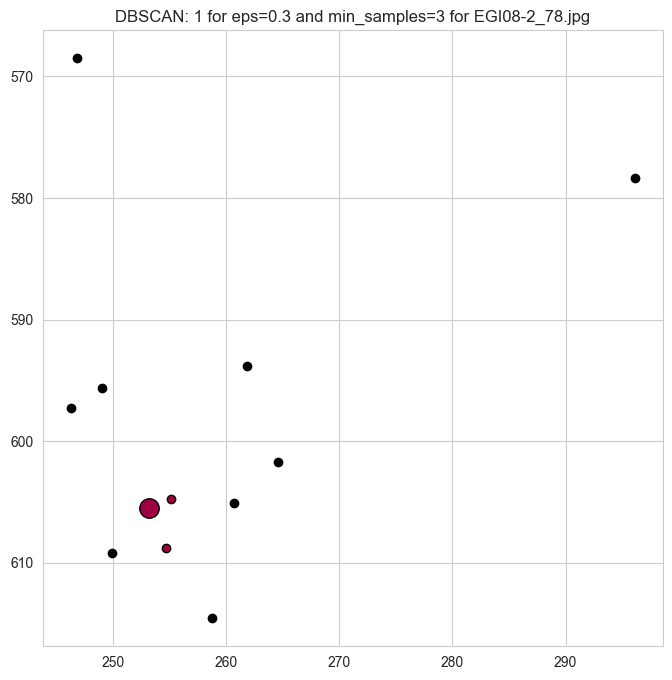

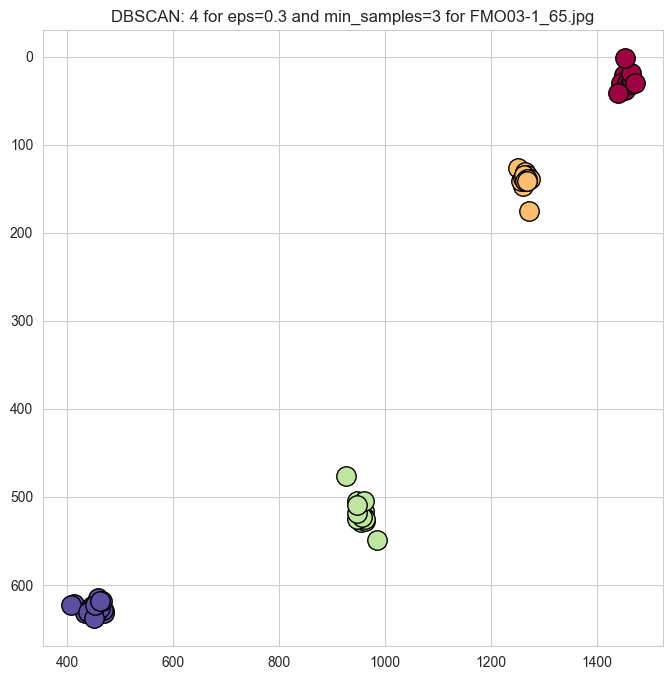

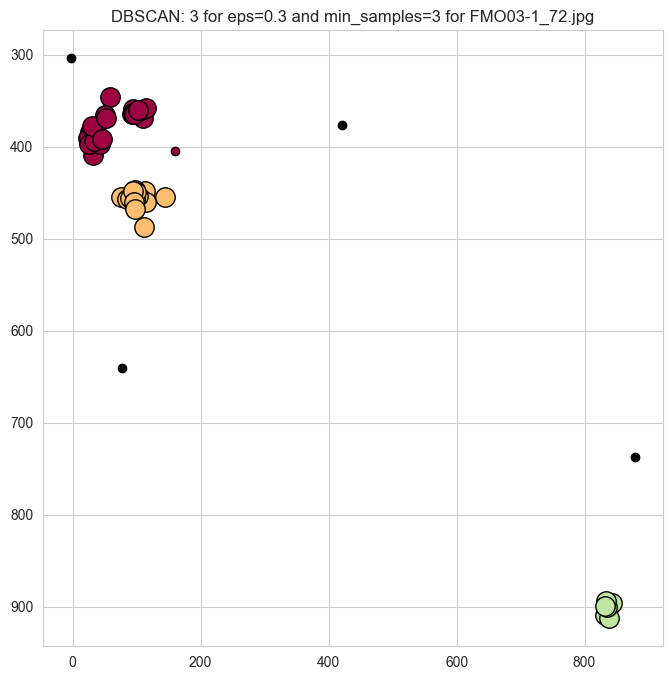

/var/folders/2k/78nn7s4548986wsjh29rhj9w0000gn/T/ipykernel_13488/648601844.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dbscan_localization = pd.concat([*db_scan_results.values()])


In [857]:
from zooniverse.analysis import compare_dbscan_hyp_v2

eps_variants = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_variants = [3, 5, 8, 10]
if debug:
    eps_variants = [0.3]
    min_samples_variants = [3]
params = [(eps, min_samples) for eps in eps_variants for min_samples in min_samples_variants]

db_scan_results = {}
db_scan_best_results = []
db_scan_best_bic_results = []
for image_name, df_image_name in df_merged_dataset.groupby("image_name"):

    dbscan_localization = compare_dbscan_hyp_v2(
        # phase_tag=phase_tag,
        params=params,
        df_flat=df_image_name,
        # output_path=output_path,
        output_plot_path=output_plot_path,
        plot=show_plots,
        
    )

    db_scan_results[image_name] = pd.DataFrame(dbscan_localization)
    
    # TODO Here lies the main problem with DBSCAN.
    ## DBSCAN tends to classfy all points as noise if min_samples is too high. Often only a single user marked an iguana.
    ## Sillouette Scoring needs a minimum of 2 clusters
    ## if there are points in decent radius they will belong to a cluster
    # if pd.DataFrame(dbscan_localization).dbscan_count.max() == 1:
    #     db_scan_best_results.append(pd.DataFrame(dbscan_localization).sort_values("dbscan_count", ascending=False).iloc[0])
    #     db_scan_best_bic_results.append(pd.DataFrame(dbscan_localization).sort_values("dbscan_count", ascending=False).iloc[0])
    # # If two or more cluster seem to exists take ones with the best BIC or Silouette score
    # else:  
    # take the best result by silouette score if there are more clusters then 1
    ## TODO make the sorting deterministic
    db_scan_best_results.append(pd.DataFrame(dbscan_localization).sort_values("dbscan_silouette_score", ascending=False).iloc[0])
    
df_dbscan_localization = pd.concat([*db_scan_results.values()])
df_scan_best_results = pd.DataFrame(db_scan_best_results)



In [858]:
df_scan_best_results

,image_name,dbscan_count,dbscan_noise,dbscan_silouette_score,dbscan_BIC_score,eps,min_samples
0,EGI08-2_78.jpg,1,9,NaN,NaN,0.3,3
0,FMO03-1_65.jpg,4,0,0.948266,-622.156765,0.3,3
0,FMO03-1_72.jpg,3,4,0.570433,-568.734316,0.3,3


Here it can be seen why the silouette score is difficult because it is often undefined.

In [859]:
## save the combinations of parameters, which maximized the silouette score.

df_dbscan_localization.to_csv(config["dbscan_hyperparam_grid"])
df_scan_best_results

,image_name,dbscan_count,dbscan_noise,dbscan_silouette_score,dbscan_BIC_score,eps,min_samples
0,EGI08-2_78.jpg,1,9,NaN,NaN,0.3,3
0,FMO03-1_65.jpg,4,0,0.948266,-622.156765,0.3,3
0,FMO03-1_72.jpg,3,4,0.570433,-568.734316,0.3,3


In [860]:
df_scan_best_results.rename(columns={"dbscan_count": "dbscan_count_sil" }, inplace=True)

df_comparison = df_comparison.merge(df_scan_best_results, on='image_name', how='left')

In [861]:
df_comparison.fillna(0, inplace=True)

mse_errors["dbscan_count_sil_rmse"] = mean_squared_error(df_comparison.count_total, df_comparison.dbscan_count_sil, squared=False)

pd.Series(mse_errors)

median_count_rmse        0.816497
mean_count_rmse          1.199847
mode_count_rmse          0.577350
dbscan_count_sil_rmse    0.816497
dtype: float64

In [862]:

df_comparison = df_comparison.drop(["dbscan_noise", "dbscan_silouette_score", "eps", "min_samples", "dbscan_BIC_score", "with_noise", "bic_avg"], axis=1, errors="ignore")
df_comparison

,image_name,subject_id,count_total,median_count,mean_count,mode_count,users,sum_annotations_count,annotations_count,dbscan_count_sil
0,EGI08-2_78.jpg,72333835,1,1.0,1.00,1,12,12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
1,FMO03-1_65.jpg,72338628,5,4.0,3.42,4,19,65,"[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, ...",4
2,FMO03-1_72.jpg,72338635,4,3.0,2.65,4,20,53,"[1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, ...",3


### HDBSCAN clustering for each image

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html#sklearn.cluster.HDBSCAN states: "A distance threshold. Clusters below this value will be merged."



2024-02-08 15:07:57.505 | INFO     | zooniverse.utils.plotting:plot_clusters_v2:268 - /Users/christian/data/zooniverse/2024_02_07_expert_goldstandard_analysis/Iguanas 2nd launch/plots/EGI08-2_78.jpg_hdbscan_bic_n=1.png


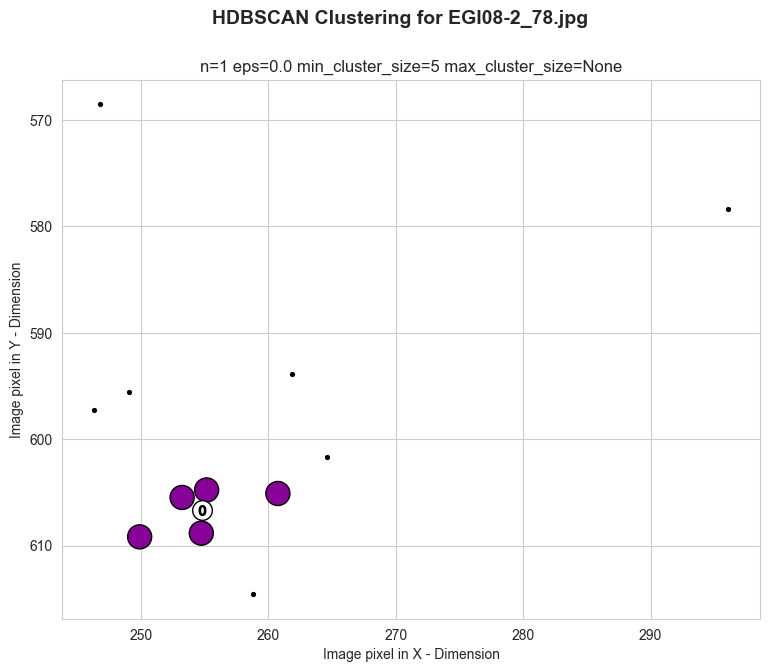

2024-02-08 15:07:57.775 | INFO     | zooniverse.utils.plotting:plot_clusters_v2:268 - /Users/christian/data/zooniverse/2024_02_07_expert_goldstandard_analysis/Iguanas 2nd launch/plots/FMO03-1_65.jpg_hdbscan_bic_n=4.png


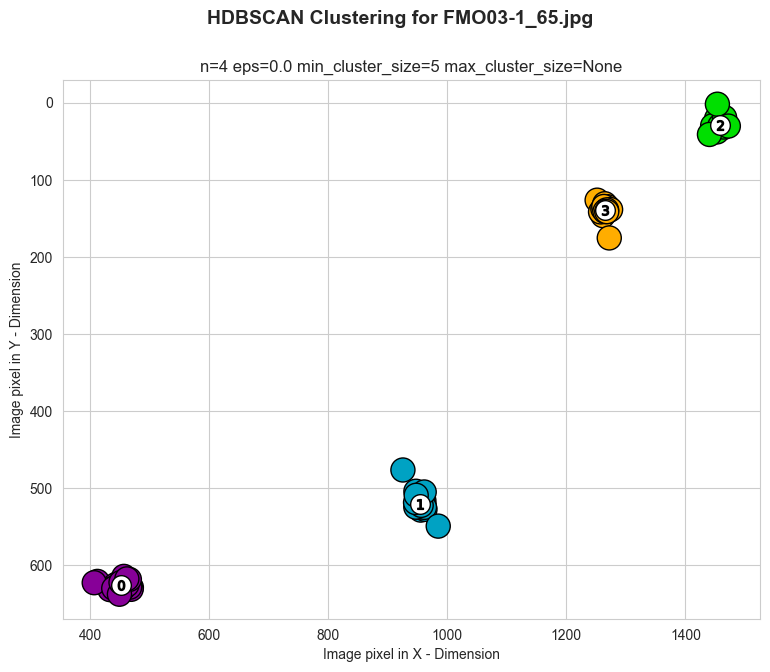

2024-02-08 15:07:58.095 | INFO     | zooniverse.utils.plotting:plot_clusters_v2:268 - /Users/christian/data/zooniverse/2024_02_07_expert_goldstandard_analysis/Iguanas 2nd launch/plots/FMO03-1_72.jpg_hdbscan_bic_n=4.png


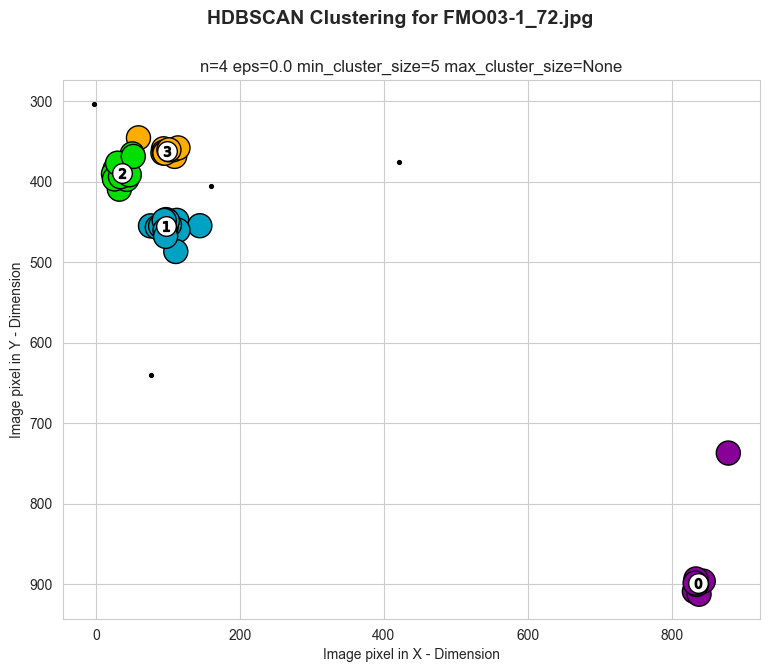

In [863]:
from zooniverse.analysis import HDBSCAN_Wrapper

hdbscan_values = []

eps_variants = [0.0] # 0 is the default
min_cluster_sizes = [5] # 5 is the default


for image_name, df_image_name in df_merged_dataset.groupby("image_name"):
    annotations_count = get_mark_overview(df_image_name)
    annotations_count_stats = get_annotation_count_stats(annotations_count=annotations_count,
                                                         image_name=df_image_name.iloc[0]["image_name"])
    
    
    if df_image_name.shape[0] >= 5: # if less then min_cluster_sizes points are available clustering makes no sense
        params = [(eps, min_cluster_size, max_cluster_size) 
                    for eps in eps_variants
                    for min_cluster_size in min_cluster_sizes
                    for max_cluster_size in [None]
              ]

        df_hdbscan = HDBSCAN_Wrapper(df_marks=df_image_name[["x", "y"]],
                                     annotations_count=annotations_count,
                                     output_path=output_plot_path,
                                     plot=show_plots,
                                     show=show_plots,
                                     image_name=image_name,
                                     params=params)
        hdbscan_values.append(df_hdbscan)


df_hdbscan = pd.concat(hdbscan_values)



In [864]:
df_hdbscan.drop(["with_noise", "bic_avg"], axis=1, inplace=True)
df_hdbscan

,image_name,HDBSCAN_count,eps,min_cluster_size,max_cluster_size,noise_points
0,EGI08-2_78.jpg,1,0.0,5,None,7
0,FMO03-1_65.jpg,4,0.0,5,None,0
0,FMO03-1_72.jpg,4,0.0,5,None,4


In [865]:
df_comparison = df_comparison.merge(df_hdbscan, on='image_name', how='left')


df_comparison["count_total"].sum()

10

In [866]:
df_comparison.to_csv(config["comparison_dataset"])
print(f"saved {config['comparison_dataset']}")

saved /Users/christian/data/zooniverse/2024_02_07_expert_goldstandard_analysis/Iguanas 2nd launch/Iguanas 2nd launch_method_comparison.csv


In [867]:
df_comparison.count_total.fillna(0, inplace=True)
df_comparison.HDBSCAN_count.fillna(0, inplace=True)

mse_errors["hdbscan_count_rmse"] = mean_squared_error(df_comparison.count_total, df_comparison.HDBSCAN_count, squared=False)


# A look into the results
Root Means Squared Error for the different methods

In [868]:
df_rmse = pd.DataFrame(pd.Series(mse_errors).sort_values())

df_rmse.to_csv(config["rmse_errors"])
df_rmse

,0
mode_count_rmse,0.577350
hdbscan_count_rmse,0.577350
median_count_rmse,0.816497
dbscan_count_sil_rmse,0.816497
mean_count_rmse,1.199847


## The sum of the clustering
What is the sum of the methods

In [869]:

df_comparison_sum = df_comparison[["count_total", "median_count", "mean_count", "mode_count", "dbscan_count_sil", "HDBSCAN_count"]].sum().sort_values()
df_comparison_sum.to_csv(config["method_sums"])
df_comparison_sum

mean_count           7.07
median_count         8.00
dbscan_count_sil     8.00
mode_count           9.00
HDBSCAN_count        9.00
count_total         10.00
dtype: float64

In [870]:
print(f"phase_tag: {phase_tag}, user_threshold: {user_threshold}")

phase_tag: Iguanas 2nd launch, user_threshold: None


## Compare the numbers
The counts are only for images which were in the dataset after filtering.

In [871]:
if phase_tag == "Iguanas 1st launch" and not debug:
    if user_threshold == 3:
        assert df_comparison_sum["mode_count"] == 215
        assert df_comparison_sum["dbscan_count_sil"] == 222
        assert df_comparison_sum["median_count"] == 228.5
        assert df_comparison_sum["HDBSCAN_count"] == 244
        assert df_comparison_sum["count_total"] == 323
    if user_threshold is None:
        assert df_comparison_sum["mode_count"] == 221
        assert df_comparison_sum["dbscan_count_sil"] == 224
        assert df_comparison_sum["median_count"] == 235.5
        assert df_comparison_sum["HDBSCAN_count"] == 247
        assert df_comparison_sum["count_total"] == 331
        
if phase_tag == "Iguanas 2nd launch" and not debug:
    
    if user_threshold == 3:
        assert df_comparison_sum["mode_count"] == 502
        assert df_comparison_sum["dbscan_count_sil"] == 484
        assert df_comparison_sum["median_count"] == 475
        assert df_comparison_sum["HDBSCAN_count"] == 541
        assert df_comparison_sum["count_total"] == 586
    if user_threshold is None:
        assert df_comparison_sum["mode_count"] == 511
        assert df_comparison_sum["dbscan_count_sil"] == 484
        assert df_comparison_sum["median_count"] == 484.5
        assert df_comparison_sum["HDBSCAN_count"] == 541.0
        assert df_comparison_sum["count_total"] == 589.0
        
if phase_tag == "Iguanas 3rd launch" and not debug:
    
    if user_threshold == 3:
        assert df_comparison_sum["mode_count"] == 302
        assert df_comparison_sum["dbscan_count_sil"] == 309
        assert df_comparison_sum["median_count"] == 313
        assert df_comparison_sum["HDBSCAN_count"] == 357
        assert df_comparison_sum["count_total"] == 351
    if user_threshold is None:
        assert df_comparison_sum["mode_count"] == 304
        assert df_comparison_sum["dbscan_count_sil"] == 309
        assert df_comparison_sum["median_count"] == 315
        assert df_comparison_sum["HDBSCAN_count"] == 357
        assert df_comparison_sum["count_total"] == 351


### Sum of all the Methods

In [872]:
print(f"{config['method_sums'].name}")
pd.read_csv(config["method_sums"])

Iguanas 2nd launch_method_sums.csv


,Unnamed: 0,0
0,mean_count,7.07
1,median_count,8.00
2,dbscan_count_sil,8.00
3,mode_count,9.00
4,HDBSCAN_count,9.00
5,count_total,10.00


### Root Mean Squared Error

In [873]:
print(f"{config['rmse_errors'].name}")
pd.read_csv(config["rmse_errors"])

Iguanas 2nd launch_rmse_errors.csv


,Unnamed: 0,0
0,mode_count_rmse,0.577350
1,hdbscan_count_rmse,0.577350
2,median_count_rmse,0.816497
3,dbscan_count_sil_rmse,0.816497
4,mean_count_rmse,1.199847


### Comparison per Image Level

In [874]:
print(f"load {config['comparison_dataset']}")
pd.read_csv(config["comparison_dataset"])

load /Users/christian/data/zooniverse/2024_02_07_expert_goldstandard_analysis/Iguanas 2nd launch/Iguanas 2nd launch_method_comparison.csv


,Unnamed: 0,image_name,subject_id,count_total,median_count,mean_count,mode_count,users,sum_annotations_count,annotations_count,dbscan_count_sil,HDBSCAN_count,eps,min_cluster_size,max_cluster_size,noise_points
0,0,EGI08-2_78.jpg,72333835,1,1.0,1.00,1,12,12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1,0.0,5,NaN,7
1,1,FMO03-1_65.jpg,72338628,5,4.0,3.42,4,19,65,"[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, ...",4,4,0.0,5,NaN,0
2,2,FMO03-1_72.jpg,72338635,4,3.0,2.65,4,20,53,"[1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, ...",3,4,0.0,5,NaN,4


## Discussion:
Clustering works, it yields better numbers than just taking mode,median or mean annotations from the volunteers, because it takes the spatial location of the marker dots into consideration.

